# occupancy prediction - initial EDA

> Author: Trevor Bergstrom <br>
> Date: 2022-08-27 <br>
> Kernel: Python 3.10 <br>

## init

In [3]:
import os 
os.chdir('/Users/trevor/Work/1-projects/occupancy-prediction')

import numpy as np
import pandas as pd 
import pathlib 

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import altair as alt
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [4]:
DATASTORE = pathlib.Path('datastore')
assert DATASTORE.exists(), f'unable to find datastore at: {DATASTORE}'

## load data

In [9]:
data_path = DATASTORE.joinpath('occ-counts.csv')

df = (
    pd.read_csv(data_path, parse_dates=['timestamp'])
    .drop(columns=['subLabel', 'lastUpdate'])
    .rename(columns={'count': 'occ'})
)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22650 entries, 0 to 22649
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   location   22650 non-null  object        
 1   capacity   22650 non-null  int64         
 2   occ        22650 non-null  int64         
 3   timestamp  22650 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 707.9+ KB


None

,location,capacity,occ,timestamp
0,POP,880,177,2022-03-28 16:02:42.738457
1,UPW,160,8,2022-03-28 16:02:42.738457
2,FRE,441,126,2022-03-28 16:02:42.738457
3,POP,880,184,2022-03-28 16:04:30.367773
4,UPW,160,8,2022-03-28 16:04:30.367773


# exploration

## feature processing

In [23]:
fdf = (
    df
    .assign(
        day = lambda d: d.timestamp.dt.strftime('%w').astype('int'),
        day_ = lambda d: d.timestamp.dt.strftime('%A'),
        hour = lambda d: d.timestamp.dt.strftime('%H').astype('int'),
    )
    .query('location == "POP"')
    .query('5 < hour < 24')
)
fdf.head()

,location,capacity,occ,timestamp,day,day_,hour
0,POP,880,177,2022-03-28 16:02:42.738457,1,Monday,16
3,POP,880,184,2022-03-28 16:04:30.367773,1,Monday,16
6,POP,880,191,2022-03-28 16:04:53.611084,1,Monday,16
9,POP,880,207,2022-03-28 16:11:59.003963,1,Monday,16
12,POP,880,227,2022-03-28 16:22:04.569012,1,Monday,16


## occupancy distributions

Text(0.5, 1.0, 'POP occupancy by day of week')

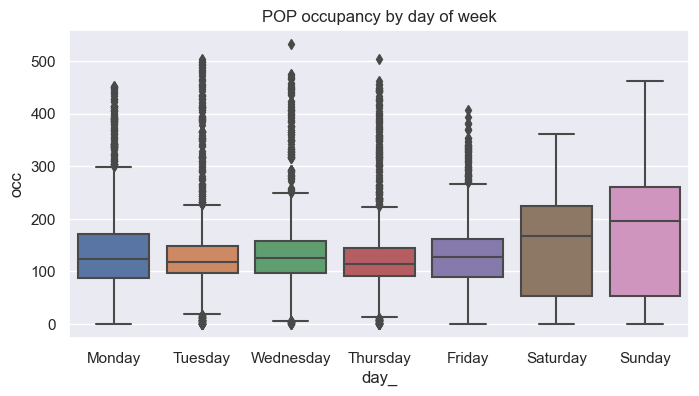

In [27]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=fdf, x='day_', y='occ')
plt.title('POP occupancy by day of week')

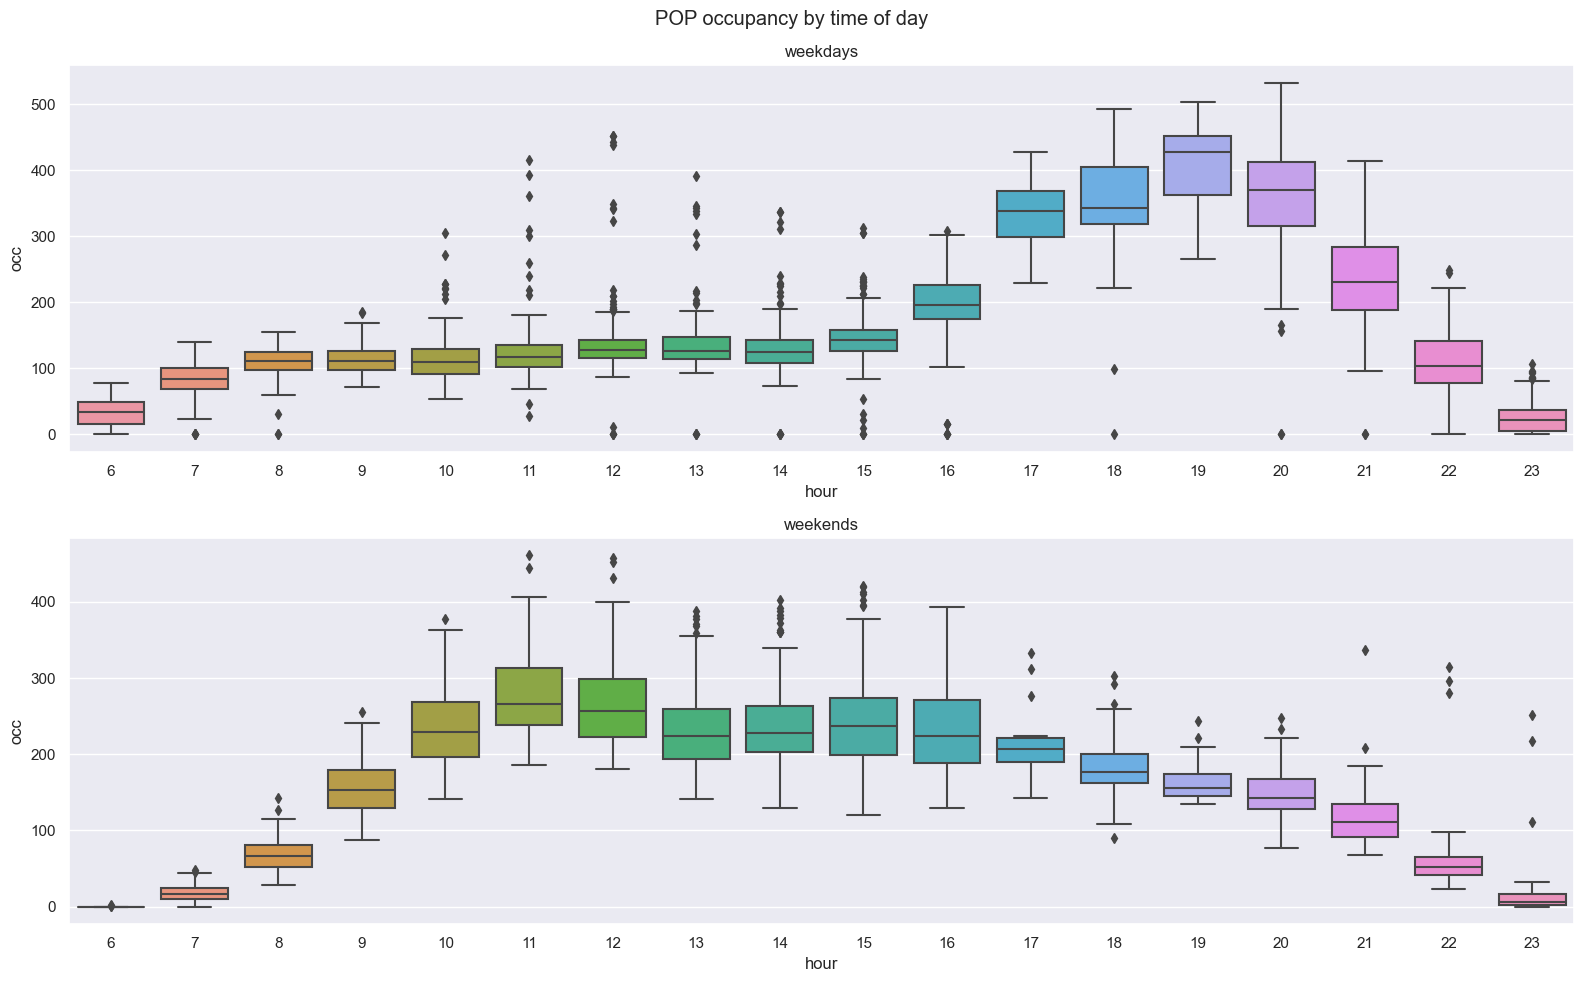

In [28]:
fig, (top, bottom) = plt.subplots(2, 1, figsize=(16, 10))

sns.boxplot(
    data=fdf.query('day_ not in ("Saturday", "Sunday")'), 
    x='hour', y='occ', ax=top,
)
top.set_title('weekdays')
sns.boxplot(
    data=fdf.query('day_ in ("Saturday", "Sunday")'), 
    x='hour', y='occ', ax=bottom,
)
bottom.set_title('weekends')
fig.suptitle('POP occupancy by time of day')
fig.tight_layout()